In [13]:
import re
import pandas as pd
import numpy as np
import random
random.seed = 23
import networkx as nx
from pathlib import Path
from collections import Counter

pd.set_option('display.max_rows', 200)

import spacy
import nltk
import string

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import word2vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

In [2]:
def get_sentence_sequences(book):
    detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = detector.tokenize(book)
    return sentences


def find_connections(sequences, characters):
    if any(len(names) > 1 for names in characters):
        df = pd.DataFrame({str(character):
                           {sequence: sum([sequence.count(name) for name in character])
                            for sequence in sequences}
                           for character in characters})
    else:
        characters = [c[0] for c in characters]
        df = pd.DataFrame([[sequence.count(character)
                            for character in characters]
                           for sequence in sequences],
                          index=sequences,
                          columns=characters)
    return df

def calculate_cooccurence(df):
    characters = df.columns.values
    cooccurence = df.values.T.dot(df.values)
    np.fill_diagonal(cooccurence, 0)
    cooccurence = pd.DataFrame(cooccurence, columns=characters, index=characters)
    return cooccurence


def get_interaction_df(cooccurence, threshold=0):
    rows, columns = np.where(np.triu(cooccurence.values, 1) > threshold)

    return pd.DataFrame(np.column_stack([cooccurence.index[rows],
                                         cooccurence.columns[columns],
                                         cooccurence.values[rows, columns]]),
                        columns=['source', 'target', 'value'])

In [3]:
df = pd.read_csv('office_corpus.csv', encoding='latin-1')

In [4]:
heroes = pd.DataFrame([['Michael', 'm'], ['Dwight', 'm'], ['Jim', 'm'], ['Pam', 'f'], ['Ryan', 'm'], ['Andy', 'm'], ['Jan', 'f'], ['Stanley', 'm'], ['Kevin', 'm'], ['Meredith', 'f'], ['Angela', 'f'], ['Phyllis', 'f'], ['Kelly', 'f'], ['Oscar', 'm'], ['Creed', 'm']], columns=['SPEAKER', 'sex'])

In [5]:
df = pd.merge(df,heroes, on=('SPEAKER'), how ='left')

In [6]:
df

,SPEAKER,UTTERANCE,EPISODE_NAME,sex
0,Michael,All right Jim. Your quarterlies look very goo...,Season 1 Episode 01,m
1,Jim,"Oh, I told you. I couldn't close it. So...",Season 1 Episode 01,m
2,Michael,So you've come to the master for guidance? Is...,Season 1 Episode 01,m
3,Jim,"Actually, you called me in here, but yeah.",Season 1 Episode 01,m
4,Michael,"All right. Well, let me show you how it's done.",Season 1 Episode 01,m
...,...,...,...,...
60036,Creed,It all seems so very arbitrary. I applied for...,Season 9 Episode 23,m
60037,Meredith,I just feel lucky that I got a chance to shar...,Season 9 Episode 23,f
60038,Phyllis,Iâm happy that this was all filmed so I can...,Season 9 Episode 23,f
60039,Jim,I sold paper at this company for 12 years. My...,Season 9 Episode 23,m


Катя

In [23]:
df_names = pd.DataFrame(df['SPEAKER'] + df['UTTERANCE'])

In [24]:
df_names

,0
0,Michael All right Jim. Your quarterlies look v...
1,"Jim Oh, I told you. I couldn't close it. So..."
2,Michael So you've come to the master for guida...
3,"Jim Actually, you called me in here, but yeah."
4,"Michael All right. Well, let me show you how i..."
...,...
60036,Creed It all seems so very arbitrary. I applie...
60037,Meredith I just feel lucky that I got a chance...
60038,Phyllis Iâm happy that this was all filmed s...
60039,Jim I sold paper at this company for 12 years....


In [66]:
book = '.'.join([str(i) for i in df_names[0]])

In [72]:
names = [tuple([character]) for character in heroes['SPEAKER']]

In [73]:
names

[('Michael',),
 ('Dwight',),
 ('Jim',),
 ('Pam',),
 ('Ryan',),
 ('Andy',),
 ('Jan',),
 ('Stanley',),
 ('Kevin',),
 ('Meredith',),
 ('Angela',),
 ('Phyllis',),
 ('Kelly',),
 ('Oscar',),
 ('Creed',)]

In [74]:
sequences = get_sentence_sequences(book)

In [75]:
df1 = find_connections(sequences, names)
cooccurence = calculate_cooccurence(df1)

In [136]:
interaction_df = get_interaction_df(cooccurence, threshold=200)
interaction_df.to_csv('200.csv')

In [179]:
interaction_df.head()

,source,target,value
0,Michael,Dwight,5156
1,Michael,Jim,3715
2,Michael,Pam,3582
3,Michael,Ryan,1223
4,Michael,Andy,1103


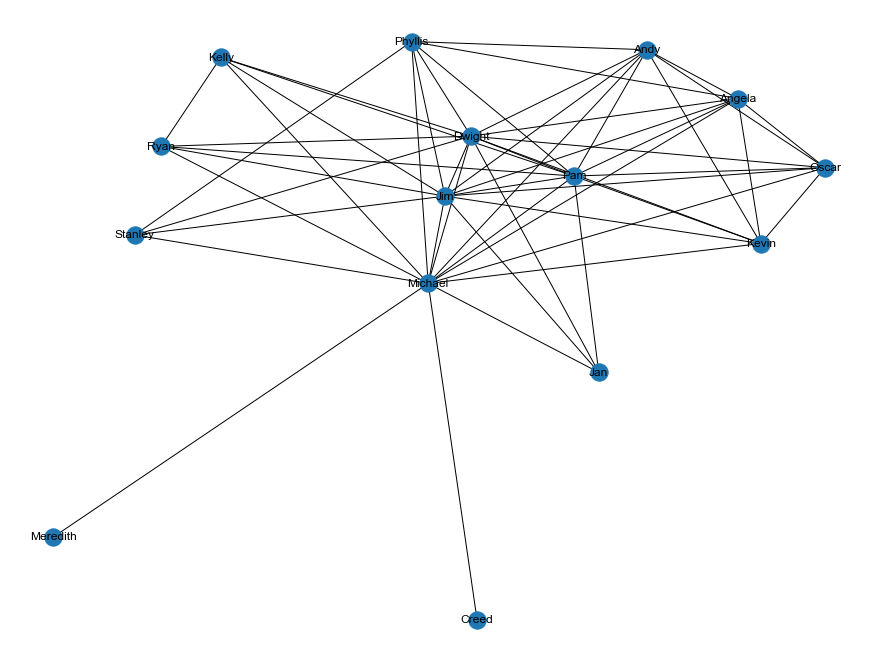

In [95]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,9)

G = nx.from_pandas_edgelist(interaction_df,
                             source='source',
                             target='target')

nx.draw(G, with_labels=True)

In [138]:
interaction_df = get_interaction_df(cooccurence, threshold=1)
interaction_df.to_csv('all.csv')

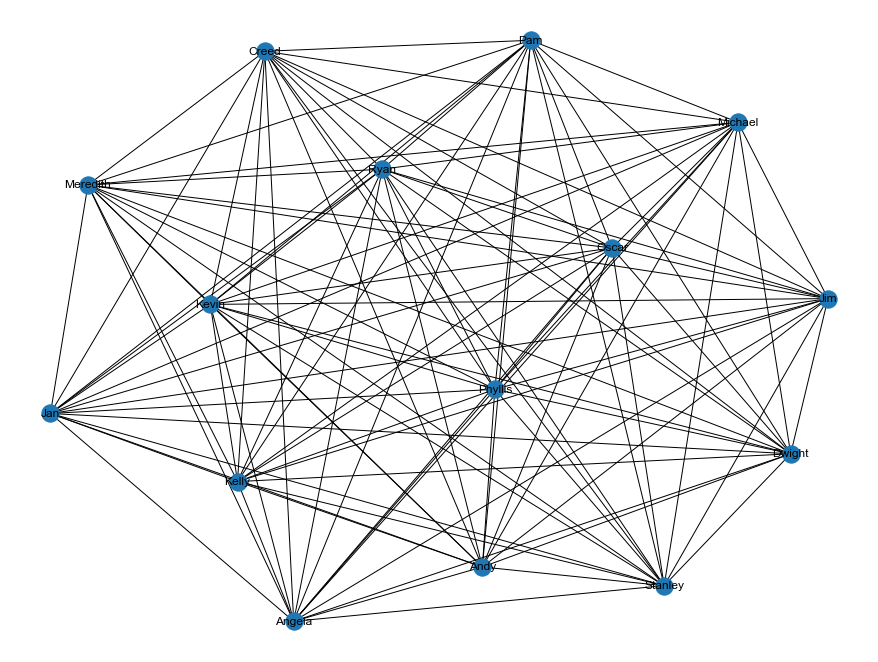

In [89]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,9)

G = nx.from_pandas_edgelist(interaction_df,
                             source='source',
                             target='target')

nx.draw(G, with_labels=True)

In [115]:
women_data = df.query('sex == "f"')
man_data = df.query('sex == "m"')

In [118]:
women_data.shape[0]

10659

In [128]:
f1_count = len([i for i in women_data['UTTERANCE'] if '!' in i])
f2_count = len([i for i in women_data['UTTERANCE'] if '?' in i])
m1_count = len([i for i in man_data['UTTERANCE'] if '!' in i])
m2_count = len([i for i in man_data['UTTERANCE'] if '?' in i])

Text(0.5, 1.0, 'Доля реплик с "!"')

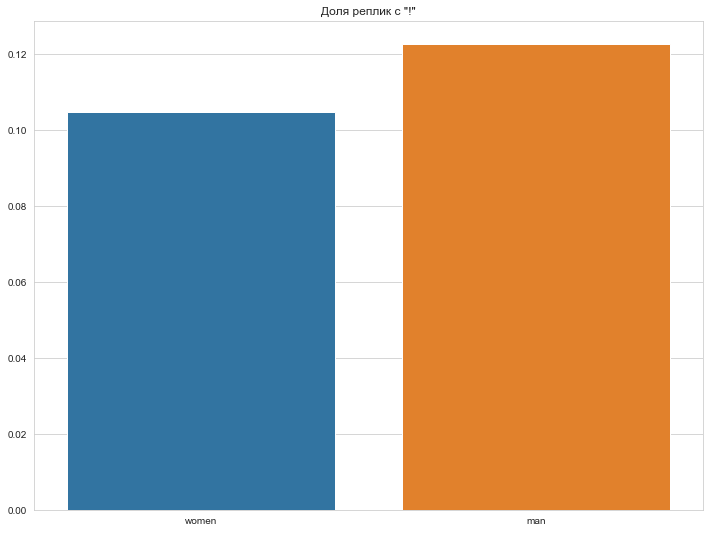

In [129]:
sns.barplot(['women', 'man'], 
            [f1_count/women_data.shape[0], m1_count/man_data.shape[0]]
           ).set_title('Доля реплик с "!"')

Text(0.5, 1.0, 'Доля реплик с "?"')

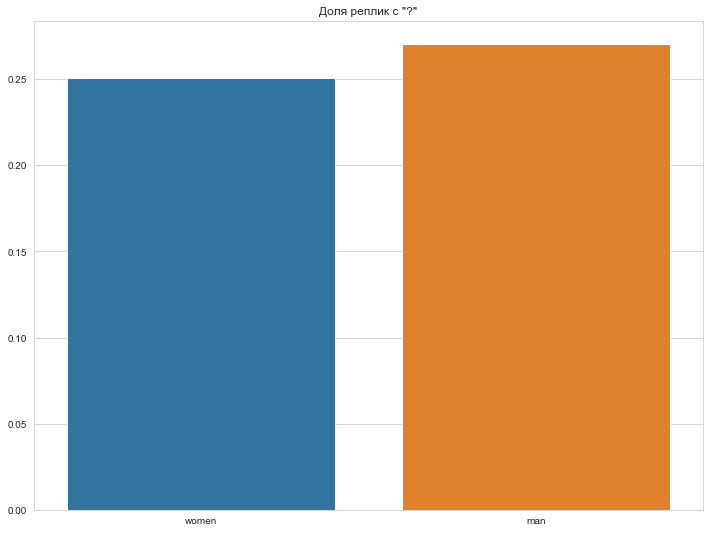

In [130]:
sns.barplot(['women', 'man'], 
            [f2_count/women_data.shape[0], m2_count/man_data.shape[0]]
           ).set_title('Доля реплик с "?"')

In [139]:
def clean(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

Для мужчин

In [142]:
man = [clean(i) for i in man_data['UTTERANCE']]

In [148]:
with open('male.txt', 'w', encoding='utf-8') as f:
    for sentense in man:
        t_sent = word_tokenize(sentense)
        text = [lem.lemmatize(i) for i in t_sent]
        print(*text, file=f)

In [151]:
f = 'male.txt'
data = gensim.models.word2vec.LineSentence(f)

In [152]:
%%time
model = gensim.models.Word2Vec(data, size=300, window=10, min_count=2, iter=50)

Wall time: 41.8 s


In [153]:
model.init_sims(replace=True)
model_path = "male.bin"

model.wv.save_word2vec_format(model_path, binary=True)

In [161]:
model = gensim.models.KeyedVectors.load_word2vec_format('male.bin', binary=True)

In [154]:
print(len(model.wv.vocab), ' слова')

8701  слова


In [156]:
model.wv.most_similar("bad", topn=10)

[('good', 0.4268772602081299),
 ('terrible', 0.41907113790512085),
 ('funny', 0.40800219774246216),
 ('difficult', 0.3919403553009033),
 ('sucky', 0.3622746765613556),
 ('such', 0.358242392539978),
 ('sad', 0.3474709689617157),
 ('busy', 0.3314213752746582),
 ('powerful', 0.3223472535610199),
 ('scary', 0.3064587712287903)]

In [158]:
model.wv.most_similar("bitch", topn=10)

[('malaysian', 0.5100477933883667),
 ('rick', 0.4058496952056885),
 ('luh', 0.3962300419807434),
 ('bitter', 0.3841527998447418),
 ('sassy', 0.3835475444793701),
 ('dork', 0.3824516534805298),
 ('reference', 0.375948041677475),
 ('dick', 0.36803093552589417),
 ('son', 0.3675590753555298),
 ('photographer', 0.36692482233047485)]

In [159]:
model.wv.most_similar("idiot", topn=10)

[('alcoholic', 0.4402959942817688),
 ('specimen', 0.4282071590423584),
 ('honk', 0.42755746841430664),
 ('alum', 0.42755433917045593),
 ('aluminum', 0.41949141025543213),
 ('xbox', 0.405551016330719),
 ('outrage', 0.403443306684494),
 ('iphone', 0.3940156400203705),
 ('identical', 0.39389723539352417),
 ('poking', 0.37670159339904785)]

Для женщин

In [162]:
women = [clean(i) for i in women_data['UTTERANCE']]

In [163]:
with open('female.txt', 'w', encoding='utf-8') as f:
    for sentense in women:
        t_sent = word_tokenize(sentense)
        text = [lem.lemmatize(i) for i in t_sent]
        print(*text, file=f)

In [164]:
f = 'female.txt'
data = gensim.models.word2vec.LineSentence(f)

In [173]:
%%time
model = gensim.models.Word2Vec(data, size=300, window=10, min_count=2, iter=50)

Wall time: 8.68 s


In [174]:
model.init_sims(replace=True)
model_path = "female.bin"

model.wv.save_word2vec_format(model_path, binary=True)

In [167]:
model = gensim.models.KeyedVectors.load_word2vec_format('female.bin', binary=True)

In [175]:
print(len(model.wv.vocab), ' слова')

3344  слова


In [176]:
model.wv.most_similar("bad", topn=10)

[('ash', 0.6359346508979797),
 ('sad', 0.5409194231033325),
 ('uncomfortable', 0.4419734477996826),
 ('struggle', 0.43714475631713867),
 ('acting', 0.41659682989120483),
 ('connection', 0.4164520502090454),
 ('overwhelmed', 0.4096476435661316),
 ('hard', 0.39600539207458496),
 ('skin', 0.3955633044242859),
 ('shy', 0.38773345947265625)]

In [177]:
model.wv.most_similar("bitch", topn=10)

[('diet', 0.8873153924942017),
 ('etiquette', 0.7771368026733398),
 ('showing', 0.6708738803863525),
 ('grinch', 0.6574578881263733),
 ('commissioned', 0.6556797027587891),
 ('shopping', 0.6535535454750061),
 ('referencing', 0.6181647777557373),
 ('sketch', 0.5986496210098267),
 ('pole', 0.586227536201477),
 ('shelf', 0.5854974985122681)]

In [178]:
model.wv.most_similar("idiot", topn=10)

[('state', 0.6529016494750977),
 ('compared', 0.641933798789978),
 ('denise', 0.6388479471206665),
 ('conducting', 0.5782859325408936),
 ('judge', 0.5678672790527344),
 ('union', 0.5619487762451172),
 ('fortune', 0.5608241558074951),
 ('cost', 0.537692129611969),
 ('united', 0.5331587791442871),
 ('seventy', 0.522162675857544)]

Семён

In [7]:
series = set(df['EPISODE_NAME'].tolist())

In [8]:
heroes = [['Michael', 'm'], ['Dwight', 'm'], ['Jim', 'm'], ['Pam', 'f'], ['Ryan', 'm'], ['Andy', 'm'], ['Jan', 'f'], ['Stanley', 'm'], ['Kevin', 'm'], ['Meredith', 'f'], ['Angela', 'f'], ['Phyllis', 'f'], ['Kelly', 'f'], ['Oscar', 'm'], ['Creed', 'm']]

In [9]:
for hero in heroes:
    hero.append(0)

In [10]:
for episode in series:
    for hero in heroes:
        hero.append(hero[2] + (len(df[(df['SPEAKER'] == hero[0]) & (df['EPISODE_NAME'] == episode)]['SPEAKER'].tolist())))
        hero[2] = hero[2] + len(df[(df['SPEAKER'] == hero[0]) & (df['EPISODE_NAME'] == episode)]['SPEAKER'].tolist())

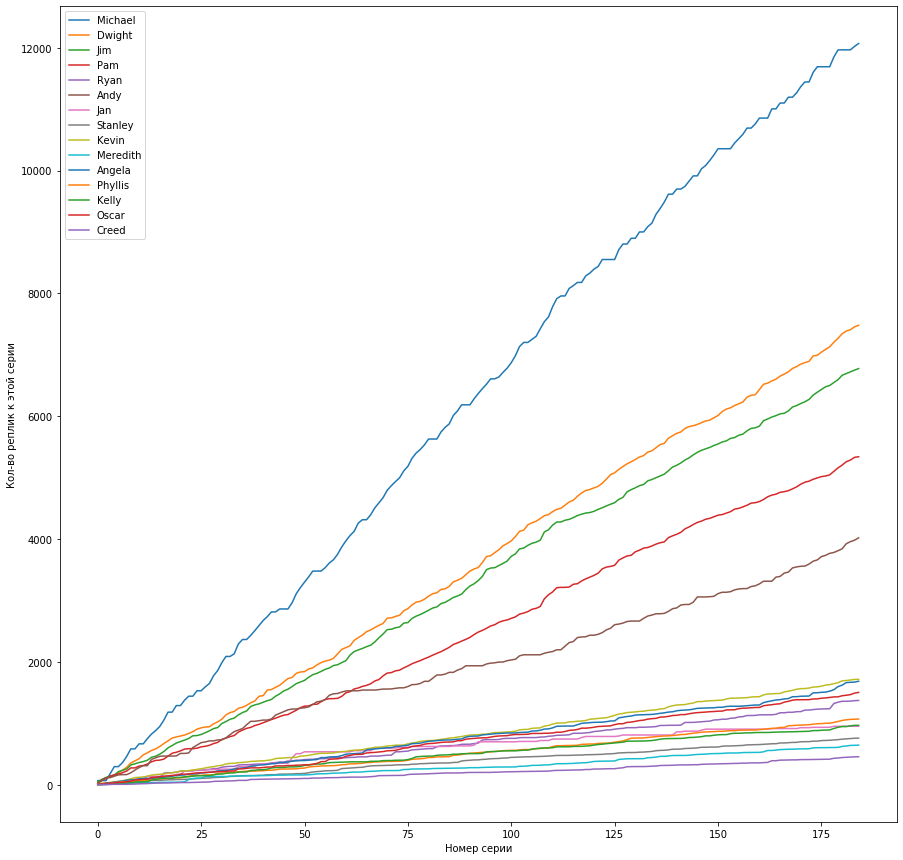

In [11]:
plt.figure(figsize=(15, 15))
numbers = list(range(len(series)))
for hero in heroes:
    plt.plot(numbers, hero[3:], label=hero[0])
plt.ylabel('Кол-во реплик к этой серии')
plt.xlabel('Номер серии')
plt.legend(loc='best') # автоматический поиск места для легенды

plt.show()

In [14]:
phrasesO = df[df['SPEAKER'] == 'Oscar']['UTTERANCE'].tolist()
phrasesS = df[df['SPEAKER'] == 'Stanley']['UTTERANCE'].tolist()
phrasesM = df[df['SPEAKER'] == 'Michael']['UTTERANCE'].tolist()
bigstringO = ''
for phrase in phrasesO:
    bigstringO = bigstringO + '' + str(phrase)
bigstringS = ''
for phrase in phrasesS:
    bigstringS = bigstringS + '' + str(phrase)
bigstringM = ''
for phrase in phrasesM:
    bigstringM = bigstringM + '' + str(phrase)

In [15]:
tokensO = word_tokenize(bigstringO)
tokensS = word_tokenize(bigstringS)
tokensM = word_tokenize(bigstringM)

In [16]:
blacking = 0
gaying = 0
b = []
g = []
for token in tokensO:
    if token.lower() == 'black':
        blacking = blacking + 1
    if token.lower() == 'gay':
        gaying = gaying + 1
b.append(blacking/len(tokensO))
g.append(gaying/len(tokensO))
blacking = 0
gaying = 0
for token in tokensS:
    if token.lower() == 'black':
        blacking = blacking + 1
    if token.lower() == 'gay':
        gaying = gaying + 1
b.append(blacking/len(tokensS))
g.append(gaying/len(tokensS))
blacking = 0
gaying = 0
for token in tokensM:
    if token.lower() == 'black':
        blacking = blacking + 1
    if token.lower() == 'gay':
        gaying = gaying + 1
b.append(blacking/len(tokensM))
g.append(gaying/len(tokensM))

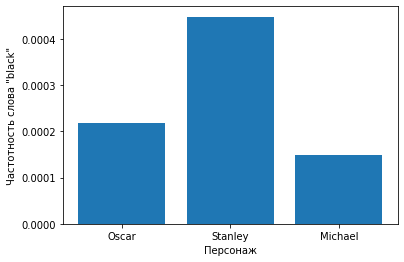

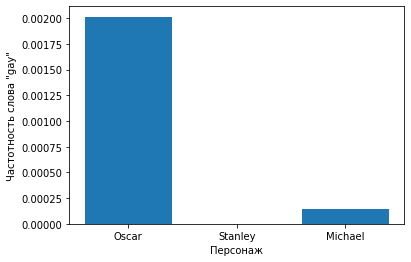

In [17]:
height = b
bars = ('Oscar', 'Stanley', 'Michael')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.ylabel('Частотность слова "black"')
plt.xlabel('Персонаж')
# Show graphic
plt.show()


height = g
bars = ('Oscar', 'Stanley', 'Michael')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.ylabel('Частотность слова "gay"')
plt.xlabel('Персонаж')
# Show graphic
plt.show()

In [18]:
heroes2 = [['Michael', 'm'], ['Dwight', 'm'], ['Jim', 'm'], ['Pam', 'f'], ['Ryan', 'm'], ['Andy', 'm'], ['Jan', 'f'], ['Stanley', 'm'], ['Kevin', 'm'], ['Meredith', 'f'], ['Angela', 'f'], ['Phyllis', 'f'], ['Kelly', 'f'], ['Oscar', 'm'], ['Creed', 'm']]

In [19]:
for hero in heroes2:
    phrases = df[df['SPEAKER'] == hero[0]]['UTTERANCE'].tolist()
    bigstring = ''
    for phrase in phrases:
        bigstring = bigstring + '' + str(phrase)
    tokens = word_tokenize(bigstring)
    fire = 0
    for token in tokens:
        if (token.lower() == 'fire') | (token.lower() == 'fired'):
            fire = fire + 1
    hero.append(fire)

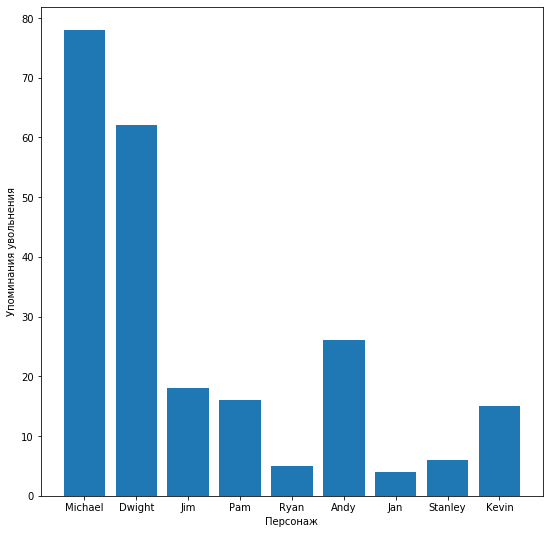

In [20]:
height = [hero[2] for hero in heroes2[:9]]
bars = [hero[0] for hero in heroes2[:9]]
y_pos = np.arange(len(bars))
plt.figure(figsize=(9, 9)) 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.ylabel('Упоминания увольнения')
plt.xlabel('Персонаж')
# Show graphic
plt.show()

Лера

In [21]:
women_data = df.query('sex == "f"')

In [22]:
male_data = df.query('sex == "m"')

In [23]:
line_lens_w = []
for line in women_data['UTTERANCE']:
    new_line = line.split(' ')
    line_lens_w.append(len(new_line))
average_wom_len = sum(line_lens_w) / len(line_lens_w)
average_wom_len 

10.871563936579417

In [24]:
line_lens_m = []
for line in male_data['UTTERANCE']:
    new_line = line.split(' ')
    line_lens_m.append(len(new_line))
average_male_len = sum(line_lens_m) / len(line_lens_m)
average_male_len 

13.45780666574471

Text(0.5, 1.0, 'Average lengh of line')

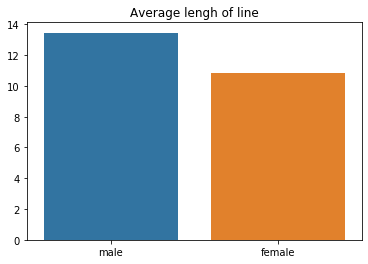

In [25]:
sns.barplot(["male", "female"], [average_male_len , average_wom_len]).set_title("Average lengh of line")

In [26]:
lines_with_sorry_w = []
for line in women_data['UTTERANCE']:
    line = line.lower()
    if 'sorry' in line or 'excuse' in line:
        lines_with_sorry_w.append(line)
sorry_proportion_w = len(lines_with_sorry_w) / len(women_data['UTTERANCE'])
sorry_proportion_w

0.01942020827469744

In [27]:
lines_with_sorry_m = []
for line in male_data['UTTERANCE']:
    line = line.lower()
    if 'sorry' in line or 'excuse' in line:
        lines_with_sorry_m.append(line)
sorry_proportion_m = len(lines_with_sorry_m) / len(male_data['UTTERANCE'])
sorry_proportion_m

0.014908034849951598

Text(0.5, 1.0, 'excuses')

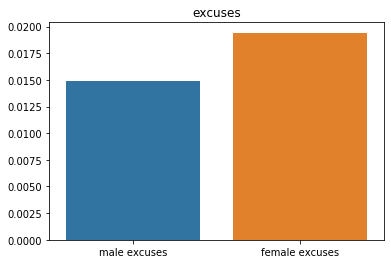

In [28]:
sns.barplot(["male excuses", "female excuses"], [sorry_proportion_m, sorry_proportion_w]).set_title("excuses")

In [29]:
hesitations = ['maybe', 'possibly', 'perhaps', 'probably']
lines_with_hes_w = []
for word in hesitations:
    for line in women_data['UTTERANCE']:
        line = line.lower()
        if word in line:
            lines_with_hes_w.append(line)
len(lines_with_hes_w)  

174

In [30]:
hesi_proportion_w = len(lines_with_hes_w) / len(women_data['UTTERANCE'])
hesi_proportion_w

0.016324233042499296

In [31]:
lines_with_hes_m = []
for word in hesitations:
    for line in male_data['UTTERANCE']:
        line = line.lower()
        if word in line:
            lines_with_hes_m.append(line)
len(lines_with_hes_m)  

607

In [32]:
hesi_proportion_m = len(lines_with_hes_m) / len(male_data['UTTERANCE'])
hesi_proportion_m

0.01678882588853547

Text(0.5, 1.0, 'hesitations')

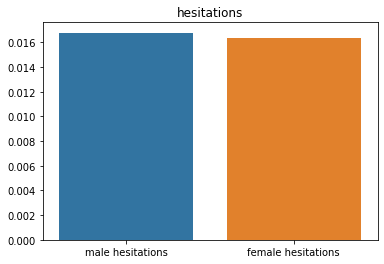

In [33]:
sns.barplot(["male hesitations", "female hesitations"], [hesi_proportion_m, hesi_proportion_w]).set_title("hesitations")